In [27]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

df = pd.read_csv('autoscout24-germany-dataset.csv')

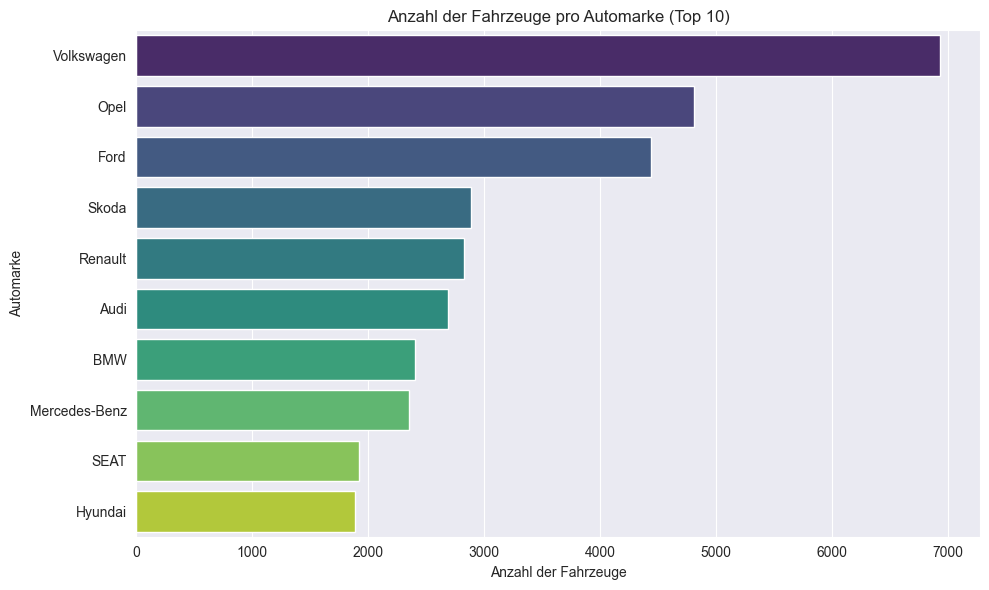

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Wähle einige Top-Marken (oder alle, wenn es nicht zu viele sind)
top_marken = df['make'].value_counts().head(10).index
df_top_marken = df[df['make'].isin(top_marken)]

# Berechne die Anzahl der Fahrzeuge pro Marke
marken_anzahl = df['make'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=marken_anzahl.values, y=marken_anzahl.index, palette='viridis', hue=marken_anzahl.index, legend=False) 
plt.title('Anzahl der Fahrzeuge pro Automarke (Top 10)')
plt.xlabel('Anzahl der Fahrzeuge')
plt.ylabel('Automarke')
plt.tight_layout()
plt.show()

kann ich präsentieren

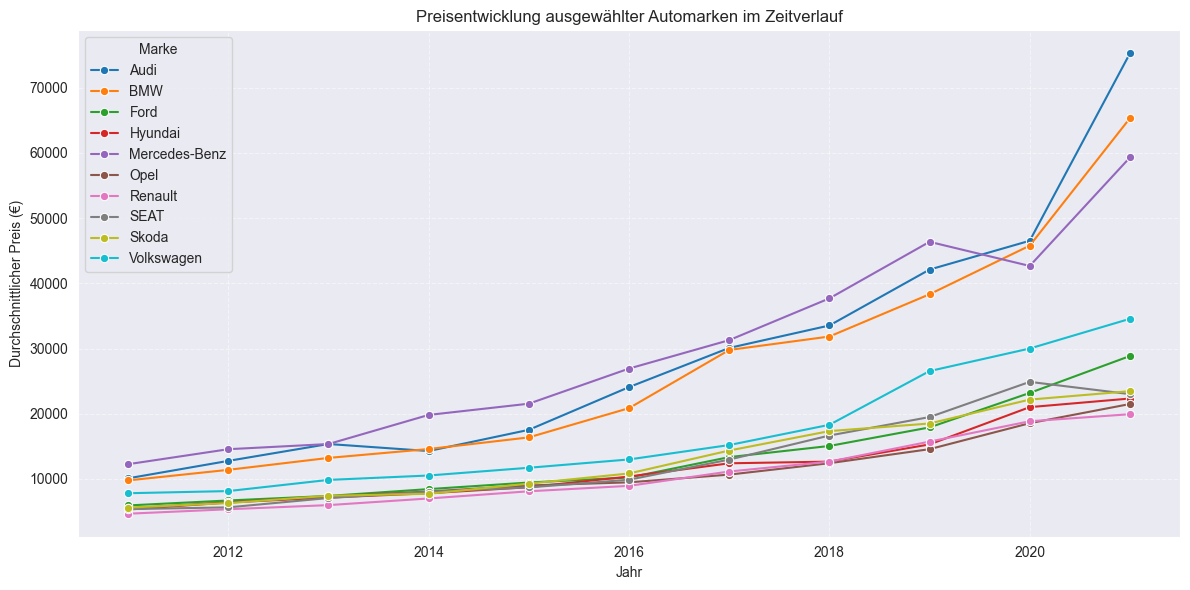

In [29]:
import seaborn as sns 
import matplotlib.pyplot as plt

# Gruppiere die Daten nach Marke und Jahr und berechne den durchschnittlichen Preis
preis_entwicklung_marke_jahr = df.groupby(['make', 'year'])['price'].mean().reset_index()

# Wähle einige Top-Marken (oder alle, wenn es nicht zu viele sind)
top_marken = df['make'].value_counts().head(10).index
df_top_marken = df[df['make'].isin(top_marken)]
preis_entwicklung_top_marken = preis_entwicklung_marke_jahr[preis_entwicklung_marke_jahr['make'].isin(top_marken)]  # Stelle sicher, dass diese Zeile ausgeführt wird

plt.figure(figsize=(12, 6))
sns.lineplot(data=preis_entwicklung_top_marken, x='year', y='price', hue='make', marker='o')  # Füge Marker hinzu
plt.title('Preisentwicklung ausgewählter Automarken im Zeitverlauf')
plt.xlabel('Jahr')
plt.ylabel('Durchschnittlicher Preis (€)')  # Füge Währungssymbol hinzu
plt.legend(title='Marke')
plt.grid(True, linestyle='--', alpha=0.5)  # Füge ein Gitternetz hinzu
plt.tight_layout()  # Verbessere das Layout
plt.show()


Fahrzeugtypen (Gear):
 gear
Manual            28752
Automatic         15141
Semi-automatic       54
Name: count, dtype: int64

Teuerste Autos:
                 make      model    price
21675        Ferrari        F12  1199900
11753        Maybach    Pullman   717078
11754  Mercedes-Benz      S 650   717078
16429        Maybach    Pullman   499800
29257  Mercedes-Benz        SLS   465000
7384     Lamborghini  Aventador   449900
7383     Lamborghini  Aventador   439900
18419        Ferrari        812   439900
2170     Lamborghini  Aventador   399999
42132        Porsche        991   399911

Anzahl Fahrzeuge je Hersteller:
 make
Volkswagen    6680
Opel          4576
Ford          4245
Skoda         2737
Renault       2659
Name: count, dtype: int64

Korrelation Preis vs. Kilometerstand:
             price   mileage
price    1.000000 -0.305598
mileage -0.305598  1.000000

Bestes Jahr für den Autoverkauf:
 year
2013    4096
2020    4087
2016    4087
2018    4078
2017    4072
2012    4063
20

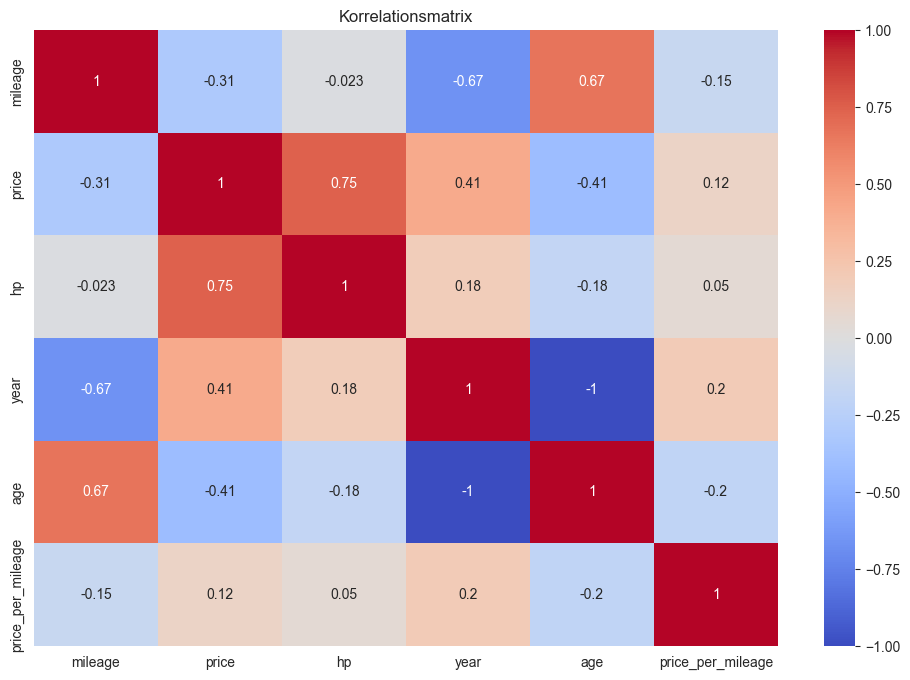

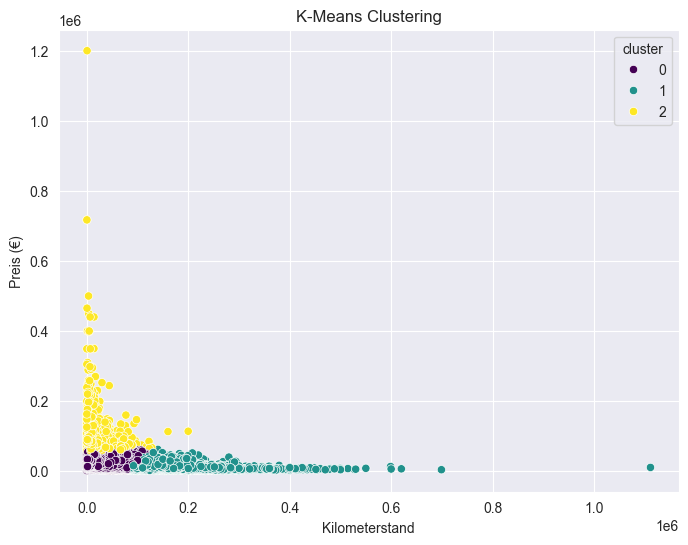

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from datetime import datetime

# 1. Datenbereinigung (wie in deinem Notebook)
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)


# 2.1 Fahrzeugtypen (Gear)
gear = df['gear'].value_counts()
print("\nFahrzeugtypen (Gear):\n", gear.head())

# 2.2 Teuerste Autos
teuer_autos = df[['make', 'model', 'price']].sort_values('price', ascending=False).head(10)
print("\nTeuerste Autos:\n", teuer_autos)

# 2.3 Anzahl Fahrzeuge je Hersteller
anzahl_hersteller = df['make'].value_counts()
print("\nAnzahl Fahrzeuge je Hersteller:\n", anzahl_hersteller.head())

# 2.4 Korrelation Preis vs. Kilometerstand
korr_Ma = df[['price', 'mileage']].corr()
print("\nKorrelation Preis vs. Kilometerstand:\n", korr_Ma)

# 2.5 Bestes Jahr für den Autoverkauf
jahr_za = df.groupby('year')['make'].count().sort_values(ascending=False)
print("\nBestes Jahr für den Autoverkauf:\n", jahr_za)

# 2.6 Beliebtheit der Kraftstoffart im Laufe der Zeit
fuel_year = df.groupby(['year', 'fuel']).size().reset_index(name='count')
beliebt_fuel = fuel_year.loc[fuel_year.groupby('year')['count'].idxmax()]
print("\nBeliebtheit der Kraftstoffart im Laufe der Zeit:\n", beliebt_fuel)

# 2.7 Preisentwicklung über die Jahre
durch_price = df.groupby('year')['price'].mean().sort_index()
print("\nPreisentwicklung über die Jahre:\n", durch_price)

# 2.8 Kosten Automatikautos mehr als Schaltgetriebe?
auto_prices = df[df['gear'] == 'Automatic']['price']
manual_prices = df[df['gear'] == 'Manual']['price']
t_stat_auto, p_val_auto = ttest_ind(auto_prices, manual_prices, equal_var=False, nan_policy='omit')
print("\nPreise Automatik vs. Schaltgetriebe:")
print(f"   Durchschnittspreis Automatik: €{auto_prices.mean():,.2f}")
print(f"   Durchschnittspreis Schaltgetriebe: €{manual_prices.mean():,.2f}")
print(f"   T-Statistik: {t_stat_auto:.2f}, P-Wert: {p_val_auto:.3f}")

# -----------------------------------------------------------------------
# 3. Erweiterte Datenanalyse und Feature Engineering
# -----------------------------------------------------------------------

# 3.1 Ausreißeranalyse (Beispiel für 'price')
def finde_ausreisser_iqr(data, spalte):
    Q1 = data[spalte].quantile(0.25)
    Q3 = data[spalte].quantile(0.75)
    IQR = Q3 - Q1
    untergrenze = Q1 - 1.5 * IQR
    obergrenze = Q3 + 1.5 * IQR
    ausreisser = data[(data[spalte] < untergrenze) | (data[spalte] > obergrenze)]
    return ausreisser

ausreisser_preis = finde_ausreisser_iqr(df, 'price')
print("\nAusreißer im Preis:")
print(ausreisser_preis.head())

# 3.2 Feature Engineering: Alter des Fahrzeugs
aktuelles_jahr = datetime.now().year
df['age'] = aktuelles_jahr - df['year']

# 3.3 Feature Engineering: Preis pro Kilometer
df['price_per_mileage'] = df['price'] / df['mileage']

# -----------------------------------------------------------------------
# 4. Visualisierungen
# -----------------------------------------------------------------------

# 4.1 Interaktive Visualisierung (Beispiel mit Plotly)
fig = px.scatter(df, x='mileage', y='price', color='make',
                  hover_data=['model', 'year'])
fig.update_layout(title='Preis vs. Kilometerstand nach Marke',
                  xaxis_title='Kilometerstand',
                  yaxis_title='Preis (€)')
#fig.show()

# 4.2 Heatmap der Korrelationsmatrix
numerische_df = df.select_dtypes(include=np.number)
korrelationsmatrix = numerische_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(korrelationsmatrix, annot=True, cmap='coolwarm')
plt.title('Korrelationsmatrix')
#plt.show()

# -----------------------------------------------------------------------
# 5. Modellierung
# -----------------------------------------------------------------------

# 5.1 Preisvorhersagemodell (Lineare Regression)
# ERSETZE 'power_kW' durch den tatsächlichen Spaltennamen für die Leistung
leistungs_spalte = 'power_kW'  # <------------------- HIER ANPASSEN!
if leistungs_spalte in df.columns:
    X = df[['mileage', 'age', leistungs_spalte]]  # Features auswählen
    y = df['price']  # Zielvariable

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33) # Aufteilen der Daten

    modell = LinearRegression()
    modell.fit(X_train, y_train)
    y_vorhersage = modell.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_vorhersage))
    r2 = r2_score(y_test, y_vorhersage)

    print(f"\nRMSE des linearen Preisvorhersagemodells: {rmse:.2f}")
    print(f"R^2 des linearen Preisvorhersagemodells: {r2:.2f}")
else:
    print(f"\nDie Spalte '{leistungs_spalte}' wurde nicht im DataFrame gefunden. Das lineare Preisvorhersagemodell konnte nicht ausgeführt werden.")

# 5.2 Polynomiale Regression
X_poly = df[['age']]
y_poly = df['price']

X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y_poly, test_size=0.2, random_state=33)

poly = PolynomialFeatures(degree=2)  # Grad des Polynoms
X_train_poly_feat = poly.fit_transform(X_train_poly)
X_test_poly_feat = poly.transform(X_test_poly)

modell_poly = LinearRegression()
modell_poly.fit(X_train_poly_feat, y_train_poly)

y_vorhersage_poly = modell_poly.predict(X_test_poly_feat)

rmse_poly = np.sqrt(mean_squared_error(y_test_poly, y_vorhersage_poly))
r2_poly = r2_score(y_test_poly, y_vorhersage_poly)

print(f"\nRMSE der polynomialen Regression: {rmse_poly:.2f}")
print(f"R^2 der polynomialen Regression: {r2_poly:.2f}")


# 5.5 K-Means Clustering
data_clustering = df[['price', 'mileage']]  # Beispiel: Clustering nach Preis und Kilometerstand
scaler = StandardScaler()
data_clustering_scaled = scaler.fit_transform(data_clustering) # Skalieren ist wichtig für K-Means

kmeans = KMeans(n_clusters=3, random_state=33, n_init=10)
df['cluster'] = kmeans.fit_predict(data_clustering_scaled)

# Visualisierung der Cluster
plt.figure(figsize=(8, 6))
sns.scatterplot(x='mileage', y='price', hue='cluster', data=df, palette='viridis')
plt.title('K-Means Clustering')
plt.xlabel('Kilometerstand')
plt.ylabel('Preis (€)')
#plt.show()

# -----------------------------------------------------------------------
# 6. Statistische Tests
# -----------------------------------------------------------------------

# 6.1 ANOVA (Beispiel: Preisunterschiede nach Getriebe)
gruppen = df['gear'].unique()
gruppen_preise = [df[df['gear'] == gruppe]['price'] for gruppe in gruppen]

f_wert, p_wert = f_oneway(*gruppen_preise)
print("\nANOVA - Preisunterschiede nach Getriebe:")
print(f"F-Wert: {f_wert:.2f}, p-Wert: {p_wert:.3f}")

# -----------------------------------------------------------------------
# 7. Ausgabe der ersten Zeilen des bearbeiteten DataFrames
# -----------------------------------------------------------------------

print("\nErste Zeilen des bearbeiteten DataFrames:")
print(df.head())

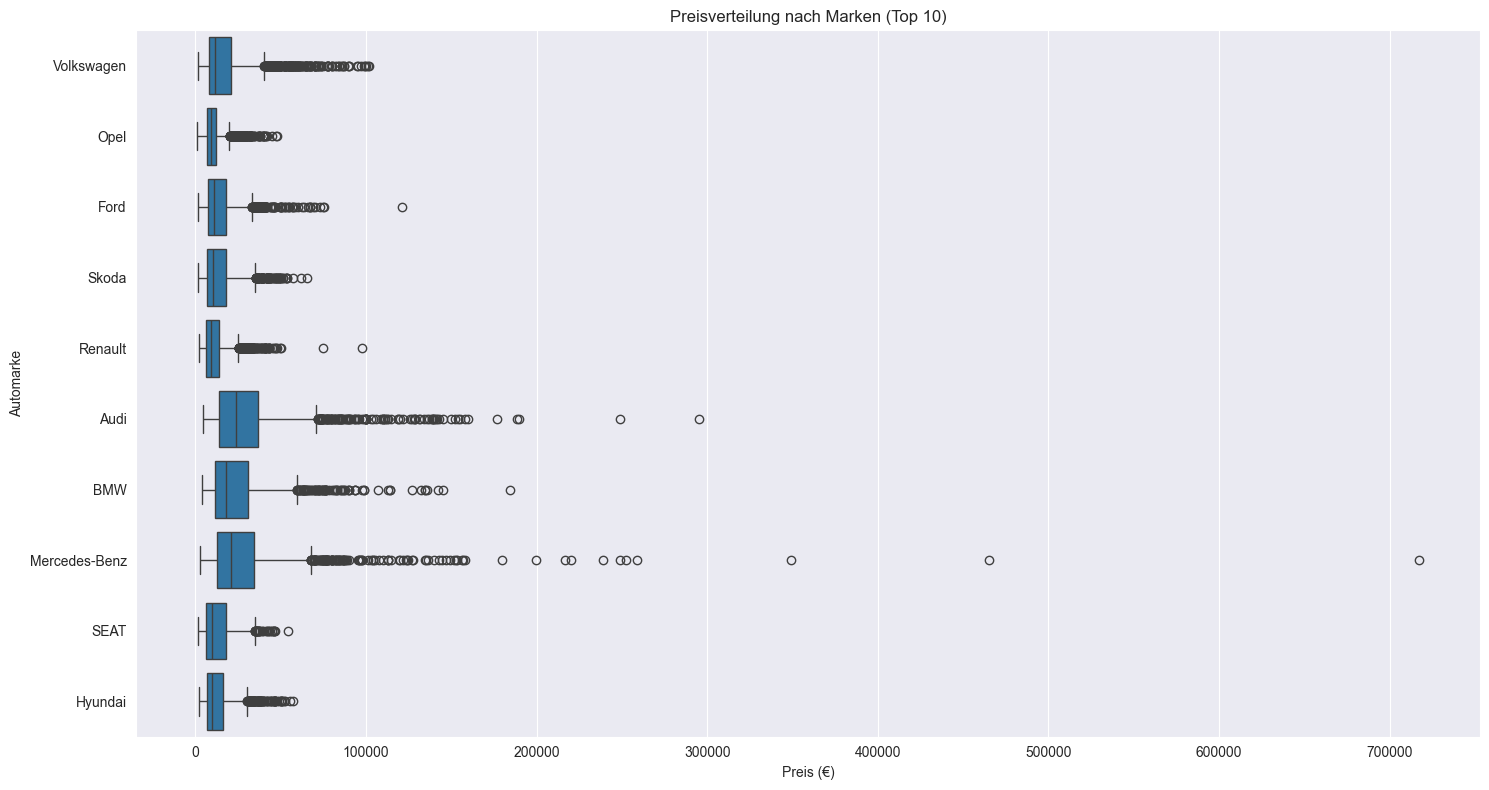

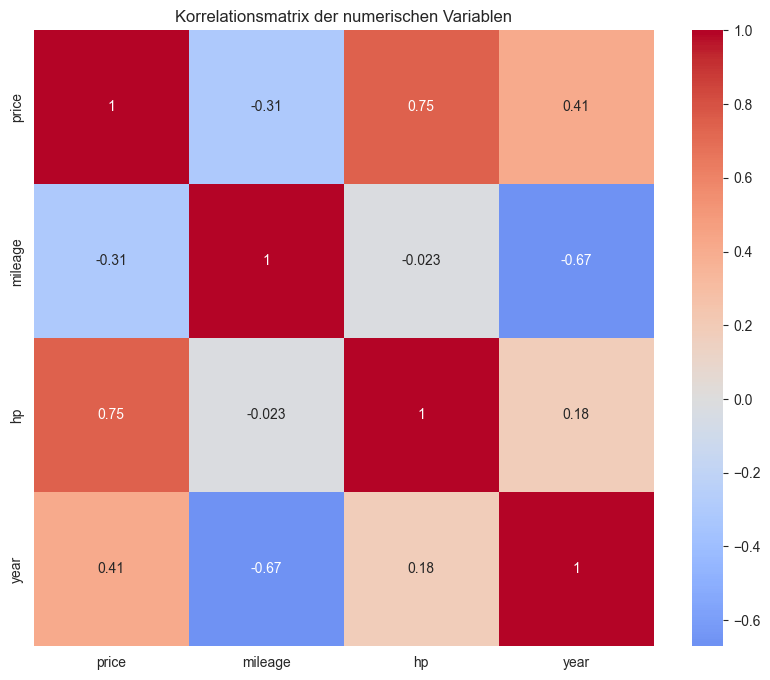

In [31]:
# Preisverteilung nach Marken
plt.figure(figsize=(15, 8))
sns.boxplot(x='price', y='make', data=df[df['make'].isin(top_marken)], 
            order=df['make'].value_counts().head(10).index)
plt.title('Preisverteilung nach Marken (Top 10)')
plt.xlabel('Preis (€)')
plt.ylabel('Automarke')
plt.tight_layout()
plt.show()

# Korrelation zwischen Preis und anderen Variablen
corr_matrix = df[['price', 'mileage', 'hp', 'year']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Korrelationsmatrix der numerischen Variablen')
plt.show()

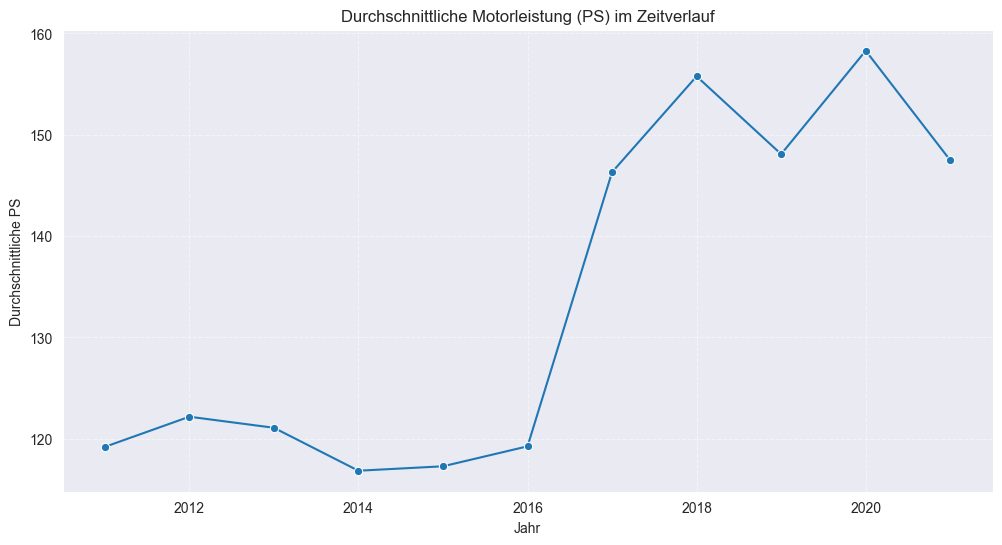

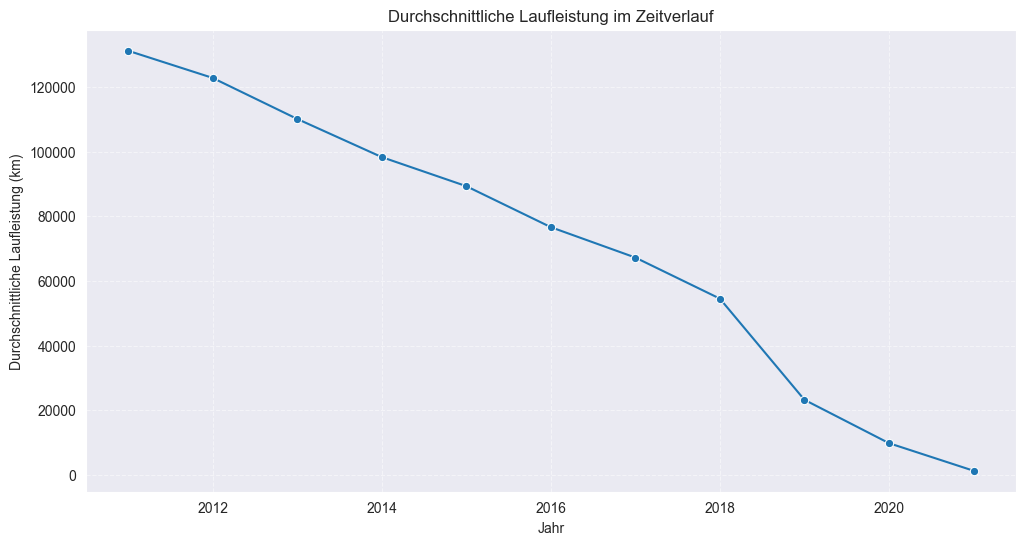

In [32]:
# Entwicklung der Motorleistung (PS) über die Jahre
plt.figure(figsize=(12, 6))
sns.lineplot(data=df.groupby('year')['hp'].mean().reset_index(), 
             x='year', y='hp', marker='o')
plt.title('Durchschnittliche Motorleistung (PS) im Zeitverlauf')
plt.xlabel('Jahr')
plt.ylabel('Durchschnittliche PS')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Entwicklung der Laufleistung über die Jahre
plt.figure(figsize=(12, 6))
sns.lineplot(data=df.groupby('year')['mileage'].mean().reset_index(), 
             x='year', y='mileage', marker='o')
plt.title('Durchschnittliche Laufleistung im Zeitverlauf')
plt.xlabel('Jahr')
plt.ylabel('Durchschnittliche Laufleistung (km)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

<Figure size 1200x600 with 0 Axes>

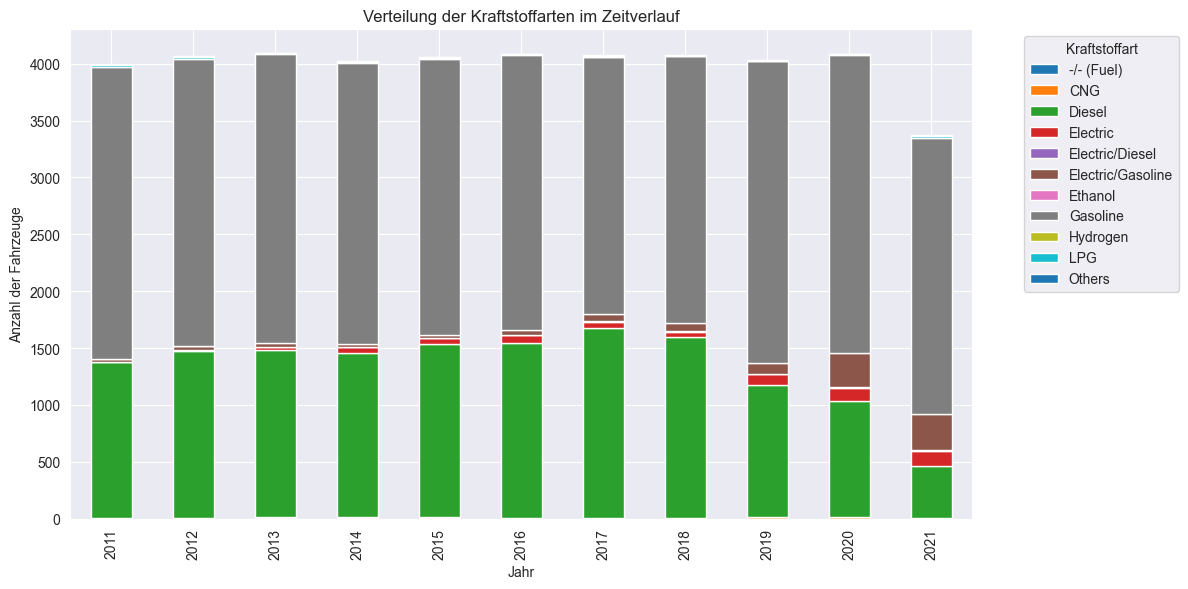

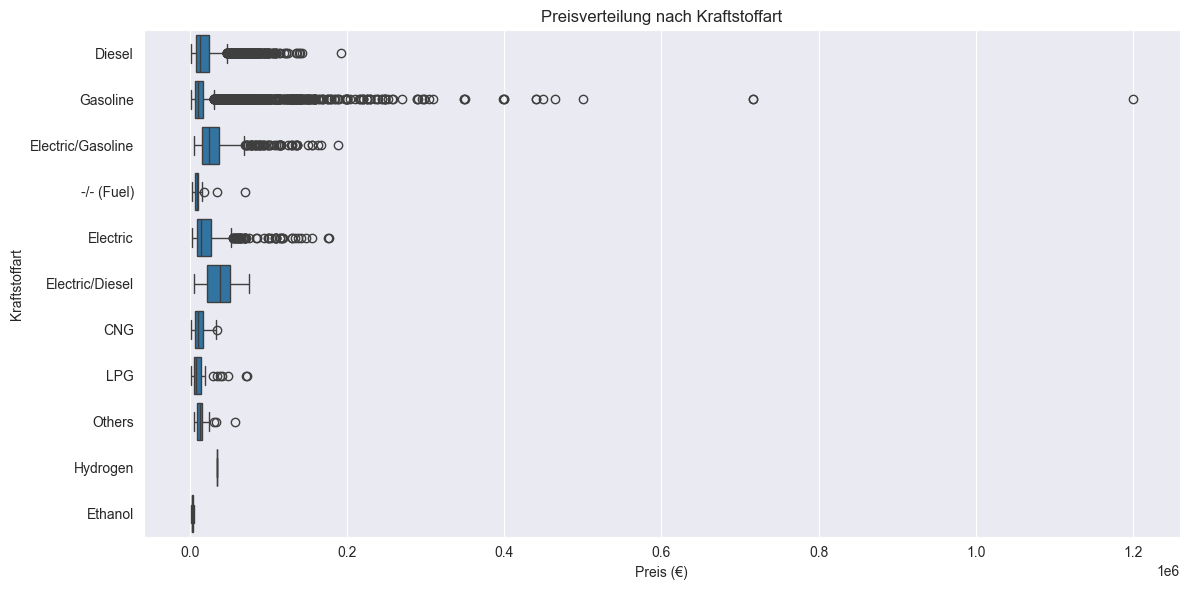

In [33]:
# Verteilung der Kraftstoffarten über die Jahre
plt.figure(figsize=(12, 6))
fuel_year_counts = df.groupby(['year', 'fuel']).size().unstack()
fuel_year_counts.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Verteilung der Kraftstoffarten im Zeitverlauf')
plt.xlabel('Jahr')
plt.ylabel('Anzahl der Fahrzeuge')
plt.legend(title='Kraftstoffart', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Durchschnittspreis nach Kraftstoffart
plt.figure(figsize=(12, 6))
sns.boxplot(x='price', y='fuel', data=df)
plt.title('Preisverteilung nach Kraftstoffart')
plt.xlabel('Preis (€)')
plt.ylabel('Kraftstoffart')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

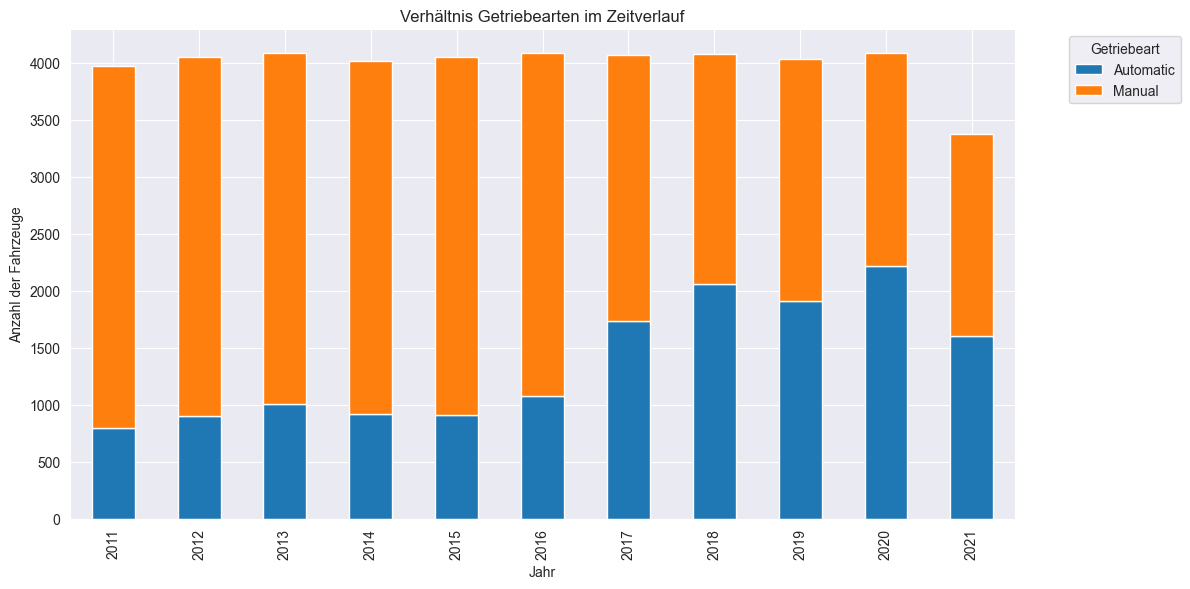

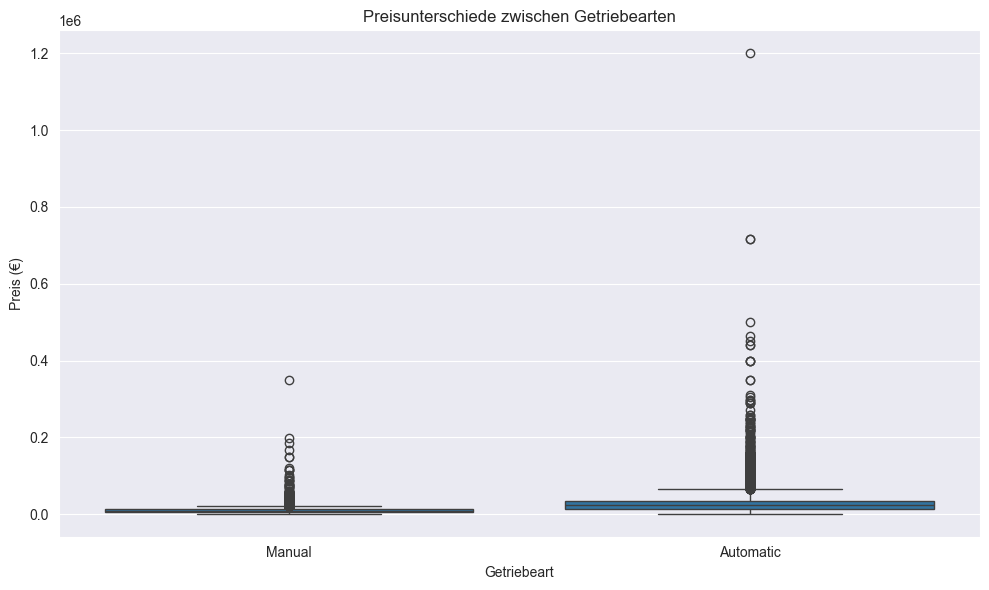

In [34]:
# Verhältnis von Automatik zu Schaltgetriebe über die Jahre
plt.figure(figsize=(12, 6))
gear_year_counts = df[df['gear'].isin(['Manual', 'Automatic'])].groupby(['year', 'gear']).size().unstack()
gear_year_counts.plot(kind='bar', stacked=True, figsize=(12,6))
plt.title('Verhältnis Getriebearten im Zeitverlauf')
plt.xlabel('Jahr')
plt.ylabel('Anzahl der Fahrzeuge')
plt.legend(title='Getriebeart', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Preisunterschiede zwischen Getriebearten
plt.figure(figsize=(10, 6))
sns.boxplot(x='gear', y='price', data=df[df['gear'].isin(['Manual', 'Automatic'])])
plt.title('Preisunterschiede zwischen Getriebearten')
plt.xlabel('Getriebeart')
plt.ylabel('Preis (€)')
plt.tight_layout()
plt.show()

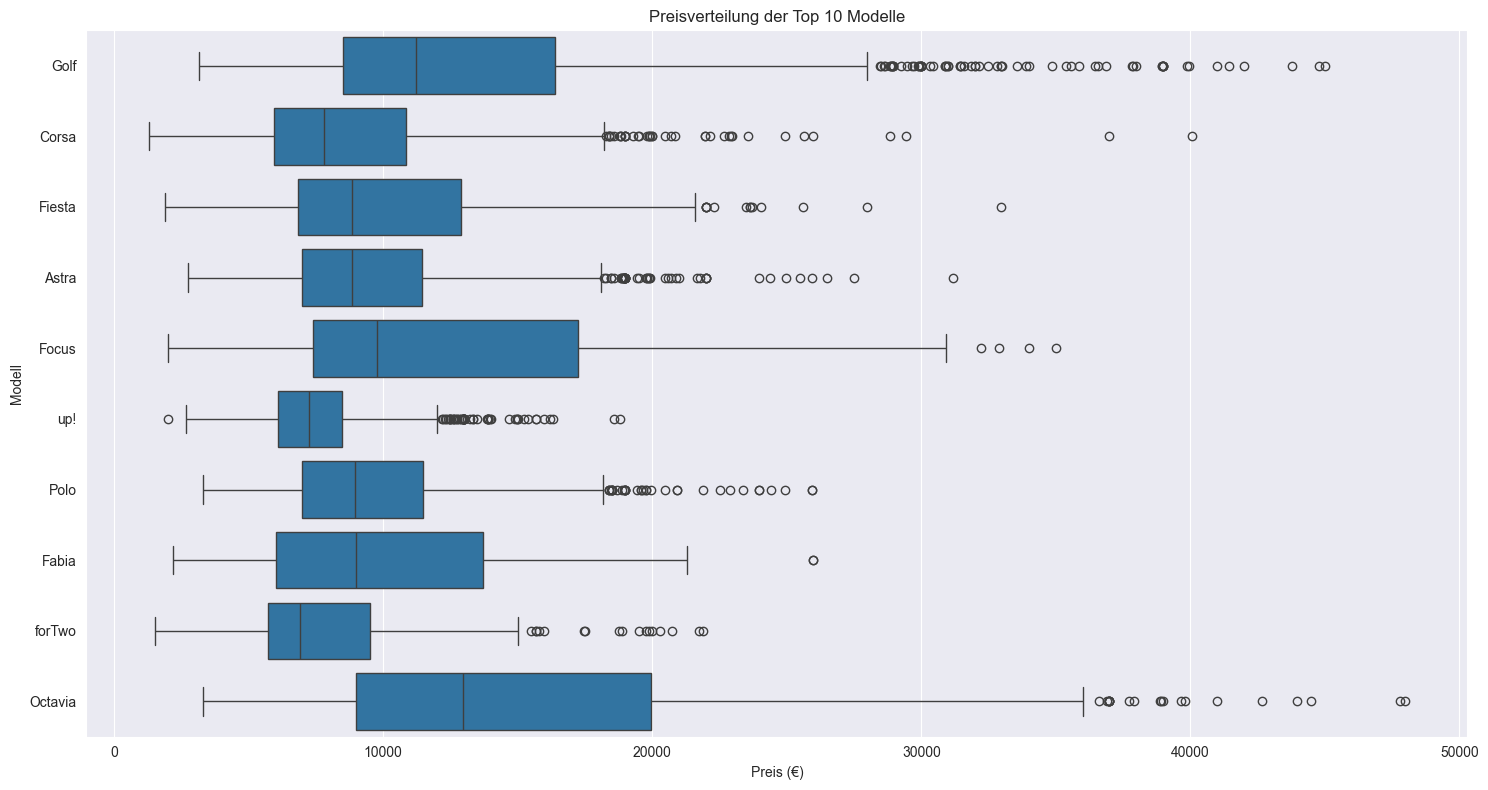

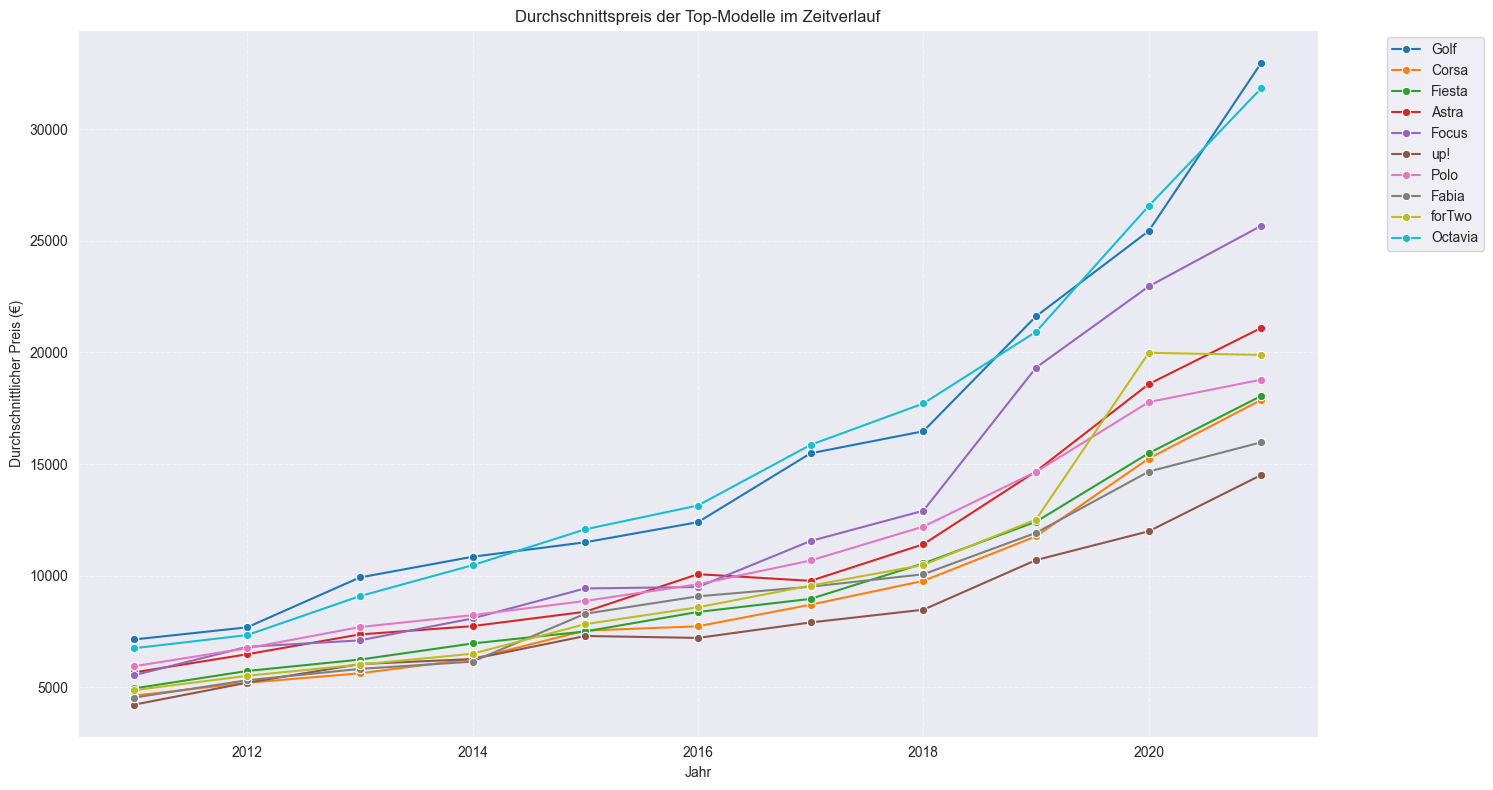

In [35]:
# Top 10 Modelle nach Anzahl
top_modelle = df['model'].value_counts().head(10).index

# Preisverteilung der Top-Modelle
plt.figure(figsize=(15, 8))
sns.boxplot(x='price', y='model', data=df[df['model'].isin(top_modelle)], 
            order=top_modelle)
plt.title('Preisverteilung der Top 10 Modelle')
plt.xlabel('Preis (€)')
plt.ylabel('Modell')
plt.tight_layout()
plt.show()

# Durchschnittspreis der Top-Modelle über die Jahre
plt.figure(figsize=(15, 8))
for model in top_modelle:
    model_data = df[df['model'] == model]
    sns.lineplot(data=model_data.groupby('year')['price'].mean().reset_index(), 
                 x='year', y='price', label=model, marker='o')
plt.title('Durchschnittspreis der Top-Modelle im Zeitverlauf')
plt.xlabel('Jahr')
plt.ylabel('Durchschnittlicher Preis (€)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()